In [1]:
import sys
import os
from copy import deepcopy

from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import EarlyStopping
import wandb

sys.path.append('..')
sys.path.append('../..')

from src.configs import DataConfig, NetConfig, NetArchitecture, FilterConfig, DataType, CNNConfig, LC_SIZE, ResNetConfig
from src.configs import DatasetType as DST, SplitStrategy as ST, RB_NAMES, RB_REGEXES
from src.utils import train, get_wandb_logger
from src.configs import PACKAGE_PATH
from src.data.data_processor import DataProcessor
from src.sweeps.sweep import DATA_CONFIG
from src.module.lightning_module import LCModule
from src.configs import AugmentType as A
from src.module.resnet import resnet20

import torch
import numpy as np
import random

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch


In [71]:

data_cfg = DataConfig(
        path=f"{PACKAGE_PATH}/Fall_2021_csv",
        output_path=f"{PACKAGE_PATH}/resources/datasets",
        # validation_path = f"{PACKAGE_PATH}/resources/SDLCD(2).csv",
        # artificial_data_path=f"{PACKAGE_PATH}/artificial_hist",
        class_names=["cz_3", "falcon_9", "atlas_V",  "h2a", "globalstar"],
        regexes=[r'CZ-3B.*', r'FALCON_9.*', r'ATLAS_[5|V]_CENTAUR_R_B$',  r'H-2A.*', r'GLOBALSTAR.*'],
        # class_names=RB_NAMES[:4],
        # regexes=RB_REGEXES[:4],
        validation_split=0.2,
        split_strategy=ST.TRACK_ID,
        number_of_training_examples_per_class=100_000,
        filter_config=FilterConfig(n_bins=30, n_gaps= 10, gap_size=5, rms_ratio= 0., non_zero_ratio=0.8),
        # filter_config=None,
        data_types=[DataType.LC],
        wavelet_start_scale=1,
        wavelet_scales_step=1,
        wavelet_end_scale=1,
        wavelet_name= 'gaus1',
        lc_shifts = 0,
        convert_to_mag=False,
        train_augmentations=[],
)
# data_cfg = DataConfig(
#         path=f"{PACKAGE_PATH}/Fall_2021_csv",
#         output_path=f"{PACKAGE_PATH}/resources/datasets",
#         # validation_path = f"{PACKAGE_PATH}/resources/SDLCD(2).csv",
#         # artificial_data_path=f"{PACKAGE_PATH}/artificial_hist",
#         class_names=["cz_3", "falcon_9", "atlas_V",  "h2a", "globalstar"],
#         regexes=[r'CZ-3B.*', r'FALCON_9.*', r'ATLAS_[5|V]_CENTAUR_R_B$',  r'H-2A.*', r'GLOBALSTAR.*'],
#         # class_names=RB_NAMES,
#         # regexes=RB_REGEXES,
#         validation_split=0.2,
#         split_strategy=ST.TRACK_ID,
#         number_of_training_examples_per_class=100_000,
#         filter_config=FilterConfig(n_bins=30, n_gaps= 3, gap_size=5, rms_ratio= 0., non_zero_ratio=0.8),
#         # filter_config=None,
#         data_types=[DataType.FS],
#         wavelet_start_scale=1,
#         wavelet_scales_step=1,
#         wavelet_end_scale=1,
#         wavelet_name= 'gaus1',
#         lc_shifts = 0,
#         convert_to_mag=False,
#         train_augmentations=[A.SHIFT],
# )



dp = DataProcessor(data_cfg)
print("LOAD")


if os.path.exists(f'{dp.output_path}/{dp.hash}'):
    dp.load_data_from_file(DST.TRAIN)
    dp.load_data_from_file(DST.ARTIFICIAL)
    # dp.load_data_from_file(type=DST.TEST)
else:
    dp.create_dataset_from_csv(DST.TRAIN)
    dp.create_dataset_from_csv(DST.ARTIFICIAL)
    # dp.create_dataset_from_csv(DST.TEST)
    dp.save_data(DST.TRAIN)
    dp.save_data(DST.ARTIFICIAL)

Hash: 369b4959c597f483fa5dc9373d42a5a4
LOAD
File /home/k/kyselica12/work/classification_of_light_curves/resources/datasets/369b4959c597f483fa5dc9373d42a5a4/artificial/labels.npy not found. Skipping...
File /home/k/kyselica12/work/classification_of_light_curves/resources/datasets/369b4959c597f483fa5dc9373d42a5a4/artificial/headers.npy not found. Skipping...
File /home/k/kyselica12/work/classification_of_light_curves/resources/datasets/369b4959c597f483fa5dc9373d42a5a4/artificial/light_curve.npy not found. Skipping...
File /home/k/kyselica12/work/classification_of_light_curves/resources/datasets/369b4959c597f483fa5dc9373d42a5a4/artificial/amplitude.npy not found. Skipping...
File /home/k/kyselica12/work/classification_of_light_curves/resources/datasets/369b4959c597f483fa5dc9373d42a5a4/artificial/light_curve.npy not found. Skipping...


In [72]:
(train_X, train_y), (val_X, val_y), _  = dp.prepare_dataset()

# data = np.load(f"{dataset_path}/train_x.npy")
# labels = np.load(f"{dataset_path}/train_y.npy")

Splitting globalstar: 100%|██████████| 1821/1821 [00:06<00:00, 272.87it/s] 


In [73]:
train_X.shape

(17573, 300)

In [74]:
import random
random.seed(42)
N = 10_000
indices = list(range(train_X.shape[0]))
indices = random.sample(indices, N)
use_data = train_X[indices]
reduced_labels = train_y[indices]
# N = 10_000
reduced_data = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=10).fit_transform(use_data)
# reduced_labels = train_y[:N]

In [75]:
reduced_data.shape, np.unique(reduced_labels)

((10000, 2), array([0., 1., 2., 3., 4.]))

<class 'numpy.bool_'>
<class 'numpy.bool_'>
<class 'numpy.bool_'>
<class 'numpy.bool_'>
<class 'numpy.bool_'>


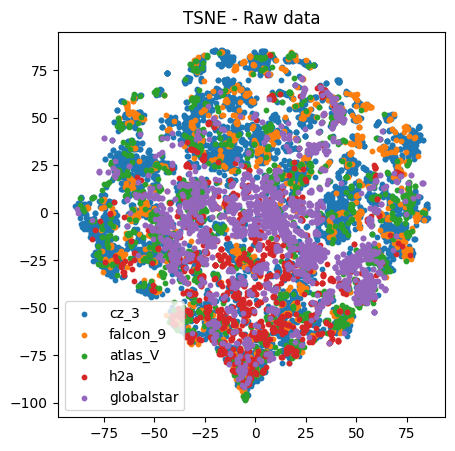

In [76]:
fig = plt.figure(figsize=(5, 5))
# ax = fig.add_subplot(projection='3d')
ax = fig.add_subplot()

for l in np.unique(reduced_labels):
    ok = reduced_labels == l
    print(type(ok[0]))
    # create 3D scatter plot
    plt.scatter(reduced_data[ok, 0], reduced_data[ok, 1], label=data_cfg.class_names[int(l)], s=10)
    # ax.scatter(reduced_data[ok, 0], reduced_data[ok, 1], reduced_data[ok, 2], label=cfg.data_config.labels[l])
plt.legend()
plt.title("TSNE - Raw data")
fig.savefig(f"method0.png")
# plt.show()

IndexError: index 2 is out of bounds for axis 1 with size 2

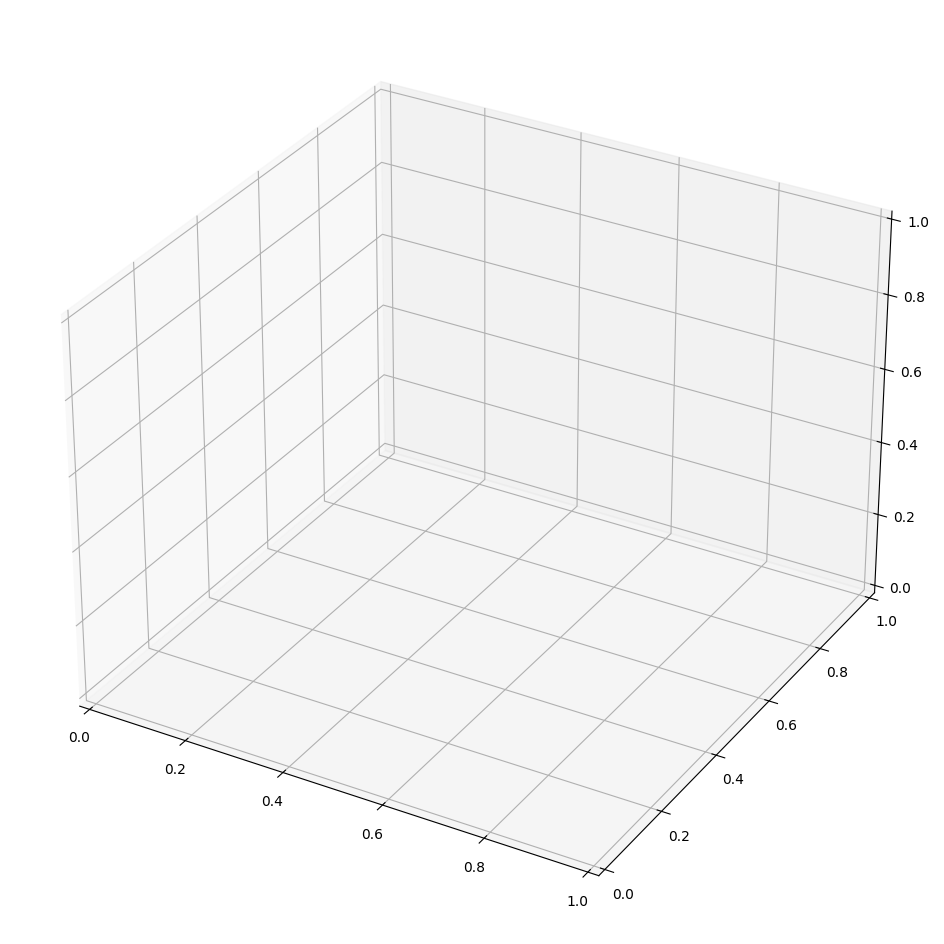

In [41]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

for l in np.unique(reduced_labels):
    ok = reduced_labels == l
    # create 3D scatter plot
    # plt.scatter(reduced_data[ok, 0], reduced_data[ok, 1], label=cfg.data_config.labels[l])
    ax.scatter(reduced_data[ok, 0], reduced_data[ok, 1], reduced_data[ok, 2], label=cfg.data_config.labels[l])
plt.legend()
plt.show()

In [65]:
import pandas as pd
df = pd.DataFrame(train_X[train_y==0])
corr = df.corr()

corr.style.background_gradient(cmap='coolwarm')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1.000000,0.098051,-0.364984,-0.096845,-0.163636,0.031738,-0.006439,-0.022026,0.127791,-0.060141,-0.186084,0.047364,0.174572,0.006146,-0.046829,-0.061746
1,0.098051,1.000000,-0.145160,-0.302436,-0.178382,-0.394192,-0.086161,0.287906,0.005735,-0.006278,-0.002669,0.099093,0.037460,-0.175197,0.011560,0.089764
2,-0.364984,-0.145160,1.000000,0.125640,-0.032454,0.072803,0.231145,0.111714,-0.023302,0.069002,0.063633,-0.091068,-0.074938,0.042127,0.007871,0.056368
3,-0.096845,-0.302436,0.125640,1.000000,0.071387,-0.433956,0.042524,0.057192,-0.082801,0.095791,0.017326,-0.125046,-0.019773,-0.029441,0.020666,-0.032287
4,-0.163636,-0.178382,-0.032454,0.071387,1.000000,0.155056,-0.094052,0.141712,-0.051708,-0.083023,0.069689,0.016188,-0.115350,0.033756,-0.006606,-0.026256
5,0.031738,-0.394192,0.072803,-0.433956,0.155056,1.000000,0.098779,-0.383762,0.045366,-0.014079,-0.029781,-0.013670,-0.035914,0.148130,0.003904,-0.086726
6,-0.006439,-0.086161,0.231145,0.042524,-0.094052,0.098779,1.000000,0.145198,-0.032530,-0.007403,-0.053146,-0.000563,0.012959,-0.000473,-0.004887,-0.020845
7,-0.022026,0.287906,0.111714,0.057192,0.141712,-0.383762,0.145198,1.000000,-0.024573,-0.077639,0.011786,0.120105,-0.060782,-0.042729,0.006623,0.028122
8,0.127791,0.005735,-0.023302,-0.082801,-0.051708,0.045366,-0.032530,-0.024573,1.000000,-0.084033,-0.442394,0.070614,0.275809,0.060825,-0.091323,-0.050415
9,-0.060141,-0.006278,0.069002,0.095791,-0.083023,-0.014079,-0.007403,-0.077639,-0.084033,1.000000,-0.016952,-0.505394,-0.114364,-0.128607,0.038439,0.320374


In [76]:
import numpy as np
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt


for i, l in enumerate(data_cfg.class_names):
    df = pd.DataFrame(train_X[train_y==i])
    corr = df.corr()
    corr = np.abs(corr.to_numpy())
    corr[corr == 1] = 0
    idx = np.argmax(corr)
    xxx = np.unravel_index(idx, corr.shape)
    print(l, xxx)
    print(np.argmax(corr))
    # plt.figure(figsize=(11,8))

# LABEL = 0
# df = pd.DataFrame(train_X[train_y==LABEL])
# print(data_cfg.class_names[LABEL])
# corr = df.corr()
# plt.figure(figsize=(11,8))
# sns.heatmap(corr, cmap="Blues",annot=True)
# plt.show()


CZ-3B (10, 12)
172
Falcon 9 (1, 3)
19
Atlas 5 Centaur (3, 7)
55
H2-A (6, 7)
103


# Wavelet transfrorm

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy import signal

In [4]:
# cfg = get_default_cfg()

cfg.data_config.dataset_class = "FourierDataset"
cfg.data_config.dataset_arguments = FourierDatasetConfig(
    amplitude=False, fourier=False,push_to_max=True,
    rms=False, residuals=False, lc=True, reconstructed_lc=False).__dict__

dataset_name = cfg.data_config.dataset_class + "_".join([f"{k}_{v}" for k,v in cfg.data_config.dataset_arguments.items()])
dataset_name += f"_{MAX_EXAMPLES}"
dataset_path = "/media/bach/DATA/work/classification_of_light_curves/output/datasets/Experiments/"
dataset_path += dataset_name
data = np.load(f"{dataset_path}/train_x.npy")
labels = np.load(f"{dataset_path}/train_y.npy")

NameError: name 'get_default_cfg' is not defined

In [19]:
IDX = 10
N = 30
widths = np.arange(1, N+1)
cwtmatr = signal.cwt(data[IDX], signal.ricker, widths)

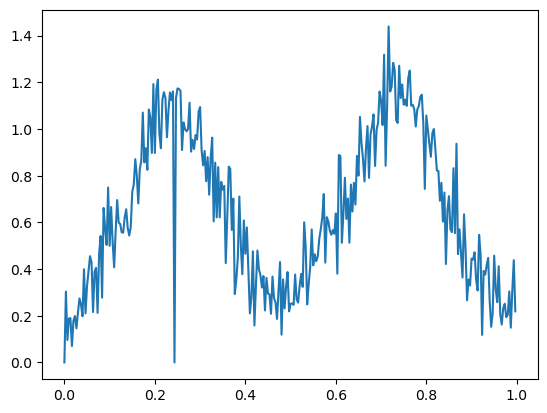

In [20]:
plt.plot(np.linspace(0,1,300, endpoint=False), data[IDX] )

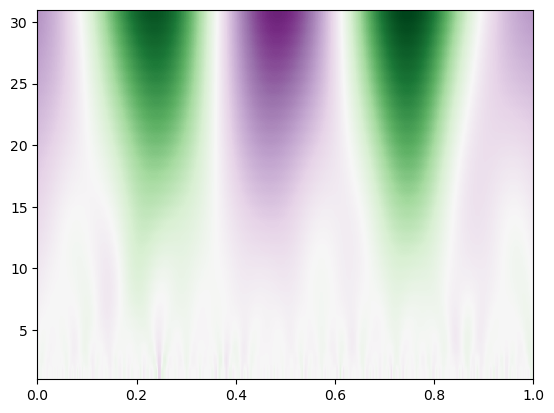

In [26]:
cwtmatr_yflip = np.flipud(cwtmatr)
plt.imshow(cwtmatr_yflip, extent=[0, 1, 1, N+1], cmap='PRGn', aspect='auto',
            vmax=abs(cwtmatr_yflip).max(), vmin=-abs(cwtmatr_yflip).max())
# plt.imshow(cwtmatr_yflip)

(10000, 9000)


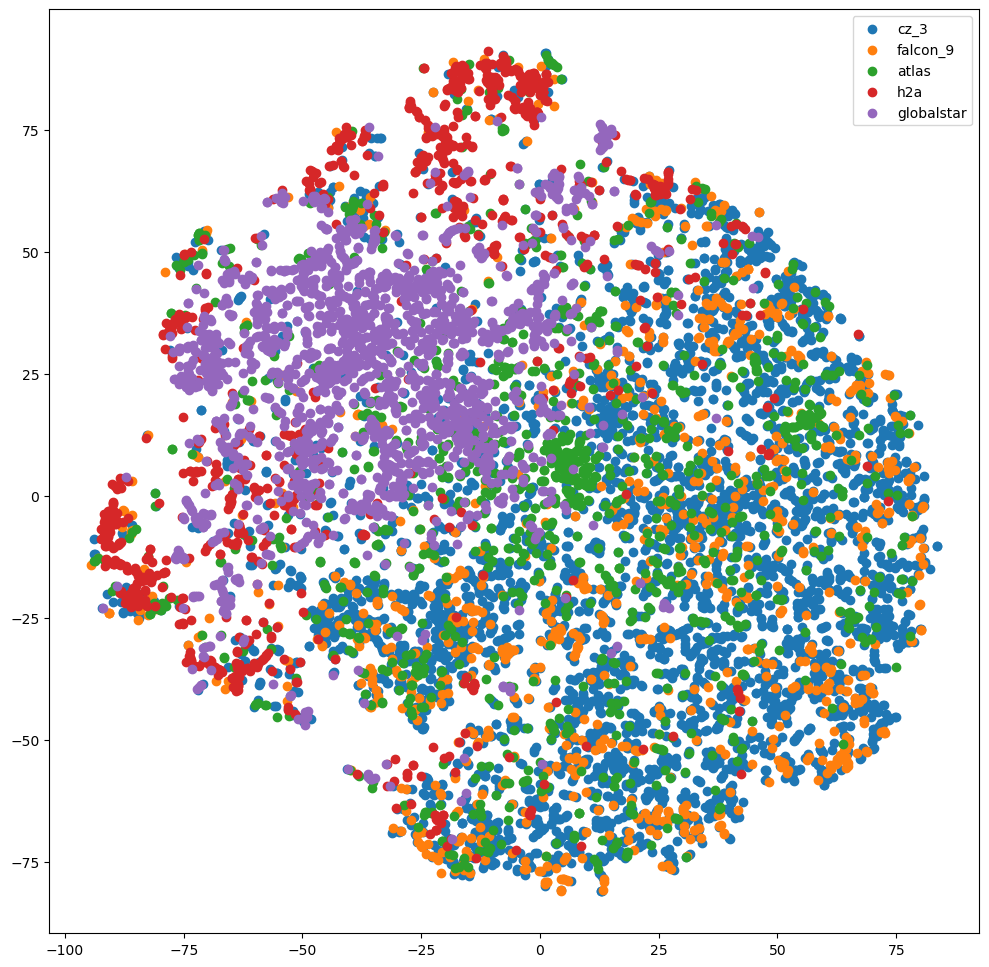

In [34]:

N = 10_000
use_data = data[:N]
use_data = np.array([signal.cwt(d, signal.ricker, widths) for d in use_data]).reshape(N, -1)
print(use_data.shape)
# N = 10_000
reduced_data = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=20).fit_transform(use_data)
reduced_labels = labels[:N]

fig = plt.figure(figsize=(12, 12))
# ax = fig.add_subplot(projection='3d')
ax = fig.add_subplot()

for l in np.unique(reduced_labels):
    ok = reduced_labels == l
    # create 3D scatter plot
    plt.scatter(reduced_data[ok, 0], reduced_data[ok, 1], label=cfg.data_config.labels[l])
    # ax.scatter(reduced_data[ok, 0], reduced_data[ok, 1], reduced_data[ok, 2], label=cfg.data_config.labels[l])
plt.legend()
plt.show()